<a href="https://colab.research.google.com/github/tuanlamdao/datascience/blob/master/6_Evaluating_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Evaluating Classifiers

In [1]:
from sklearn import (metrics, datasets, dummy,model_selection,neighbors,naive_bayes,preprocessing,multiclass)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import warnings
warnings.filterwarnings('ignore') # do not show up warnings



Compare the performance of 5 simple baseline strategies against each other based on iris dataset
1. constant: return one target class that we have picked out
2. uniform: chose evenly among the target classes based on the number of classes
3. stratified: chose evenly among the target classes based on frequency of those classes
4. prior or also called most frequency: return single most likely class  

In [2]:
iris = datasets.load_iris()
iris_train_ftrs, iris_test_ftrs, iris_train_tgt, iris_test_tgt = model_selection.train_test_split(iris.data, iris.target, test_size=.33, random_state=21)


In [3]:
strategies = ['constant','uniform','stratified','prior','most_frequent']
# setup args to create different DummyClassifier strategies
baseline_args = [{'strategy':s} for s in strategies]
baseline_args[0]['constant'] = 0 # class 0 is setosa
accuracies = []
for baseline_arg in baseline_args:
    baseline = dummy.DummyClassifier(**baseline_arg)
    baseline.fit(iris_train_ftrs,iris_train_tgt)
    baseline_preds = baseline.predict(iris_test_ftrs)
    accuracies.append(metrics.accuracy_score(baseline_preds, iris_test_tgt))
display(pd.DataFrame({'accuracy': accuracies}, index=strategies))

,accuracy
constant,0.36
uniform,0.26
stratified,0.38
prior,0.30
most_frequent,0.30


uniform and stratified will return different results when rerun multiple times ont a fixed train-test split because they are randomized methods

##### Coding confusion matrix

In [4]:
tgt_preds = (neighbors.KNeighborsClassifier().fit(iris_train_ftrs, iris_train_tgt)).predict(iris_test_ftrs)
print('accuracy:',metrics.accuracy_score(iris_test_tgt,tgt_preds))
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
print('confusion-matrix:',cm,sep="\n")

accuracy: 0.94
confusion-matrix:
[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]


Text(14.999999999999996, 0.5, 'Actual')

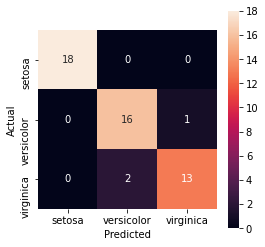

In [5]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
cm = metrics.confusion_matrix(iris_test_tgt,tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True, xticklabels=iris.target_names, yticklabels=iris.target_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

##### Dealing with multiple classes

In [6]:
macro_prec = metrics.precision_score(iris_test_tgt, tgt_preds, average='macro')
print('macro:', macro_prec)
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
n_labels = len(iris.target_names)
print("should equal 'macro average':", (np.diag(cm) / cm.sum(axis=0)).sum() / n_labels )

macro: 0.9391534391534391
should equal 'macro average': 0.9391534391534391


Setosa's precision: 1, Vericolor's precision: 16/18 and Virginica's precision: 13/14 . Mean(1,16/18,13/14) =  0.9391534391534391

In [7]:
print("micro", metrics.precision_score(iris_test_tgt, tgt_preds, average='micro'))
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
print("should equal 'micro average':", (np.diag(cm).sum() / cm.sum()))

micro 0.94
should equal 'micro average': 0.94


(18+16+13)/(18+16+13+1+2) = 0.94

Classification_report wraps several of these pieces together. It computes the one-versus-all statistics and then computes a weighted average of the values 

In [8]:
print(metrics.classification_report(iris_test_tgt, tgt_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.89      0.94      0.91        17
           2       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



##### ROC curves and Binary ROC

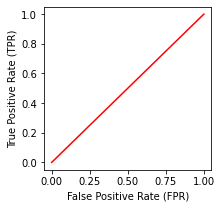

In [9]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot([0,0.5,1], [0,0.5,1], color='r')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
plt.show()

1. ROC Curve are drawn in term of TPR and FPR. It help us to compare 2 different classificaion systems. The red line (y = x) is "flip coin" - guessing way.   The classification System shoul be above the red line and system with ROC curve closer the upper left corner is the better  
2. Binary ROC: convert the mutiple target class to binary values by asking for example " Is it versicolor?". The answers are Yes/No 

FPR: [0.         0.         0.         0.06060606 0.06060606 0.12121212
 0.12121212 0.18181818 1.        ]
TPR: [0.         0.05882353 0.88235294 0.88235294 0.94117647 0.94117647
 1.         1.         1.        ]


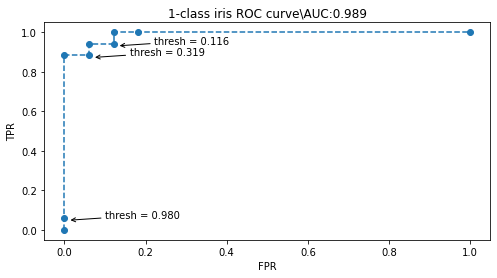

In [10]:
is_versicolor = iris.target==1 # focus on  target 1 only and evaluate the performance of predicting target 1
tts_1c = model_selection.train_test_split(iris.data, is_versicolor, test_size=.33,random_state=21)
(iris_1c_train_ftrs, iris_1c_test_ftrs, 
 iris_1c_train_tgt,  iris_1c_test_tgt) = tts_1c
gnb = naive_bayes.GaussianNB()
prob_true = (gnb.fit(iris_1c_train_ftrs, iris_1c_train_tgt).predict_proba(iris_1c_test_ftrs)[:,1])

fpr, tpr, thresh = metrics.roc_curve(iris_1c_test_tgt, prob_true)
auc = metrics.auc(fpr,tpr)
print("FPR: {}".format(fpr),
      "TPR: {}".format(tpr), sep='\n')
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(fpr,tpr,'o--')
ax.set_title("1-class iris ROC curve\AUC:{:.3f}".format(auc))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
investigate = np.array([1,3,5])
for idx in investigate:
    th, f, t = thresh[idx], fpr[idx], tpr[idx]
    ax.annotate('thresh = {:.3f}'.format(th),
               xy=(f+.01, t-.01),xytext=(f+.1,t),
               arrowprops={'arrowstyle':'->'})

FPR are betwwen 0.0 and 0.2, TPR jump quickly into range 0.9 to 1.0. Each point represents a confusion matrix

Text(87.0, 0.5, 'Actual')

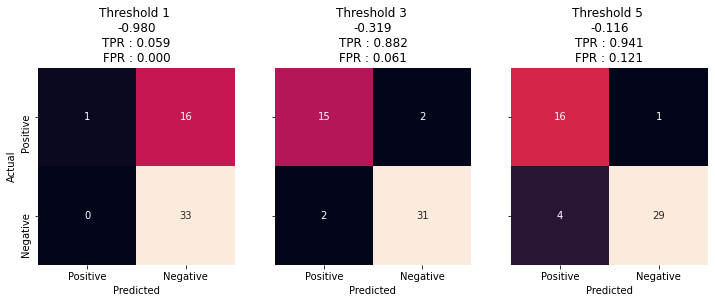

In [11]:
title_fmt = "Threshold {} \n-{:5.3f}\nTPR : {:.3f}\nFPR : {:.3f}"
pn = ['Positive' , 'Negative']
add_args = {'xticklabels':pn,
            'yticklabels':pn,
            'square':True}
fig, axes = plt.subplots(1,3,sharey = True, figsize=(12,4))
for ax, thresh_idx in zip(axes.flat, investigate):
    preds_at_th = prob_true < thresh[thresh_idx]
    cm = metrics.confusion_matrix(1-iris_1c_test_tgt, preds_at_th)
    sns.heatmap(cm, annot=True, cbar=False, ax=ax, **add_args)
    ax.set_xlabel('Predicted')
    ax.set_title(title_fmt.format(thresh_idx, thresh[thresh_idx],tpr[thresh_idx],fpr[thresh_idx]))
axes[0].set_ylabel('Actual')


we predict more things as positive as we lower the threshold

##### AUC - area under the ROC curve
Calculating AUC to summarize an ROC curve as a single value for comparing betwwen models

Text(0.5, 1.0, '10-Fold AUCs')

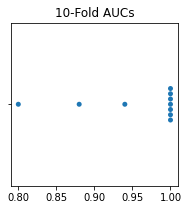

In [12]:
fixg, ax = plt.subplots(1,1,figsize=(3,3))
model = neighbors.KNeighborsClassifier(3)
cv_auc = model_selection.cross_val_score(model, iris.data, iris.target==1, scoring='roc_auc', cv=10)
ax = sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold AUCs')

chart shows many folds ( 7  folds) have perfect results

##### Multiclass learners, one versus rest and ROC

In [13]:
checkout = [0,50,100]
print("Original Encoding")
print(iris.target[checkout])


Original Encoding
[0 1 2]


we take examples 0, 50 and 100 correspond to classes 0,1 and 2. whe we binarize the class becomes 

In [14]:
print("Multi-label encoding", preprocessing.label_binarize(iris.target, [0,1,2])[checkout],sep="\n" )

Multi-label encoding
[[1 0 0]
 [0 1 0]
 [0 0 1]]


the binarize data now can interprete the first row : am I class zero? yes, no ,no 

Text(0, 0.5, 'TPR')

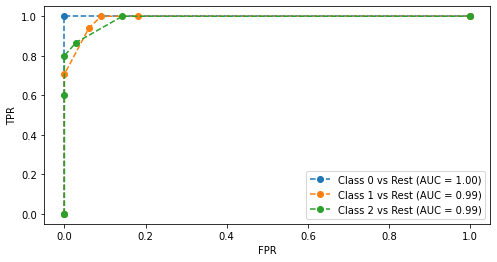

In [15]:
iris_multi_tgt = preprocessing.label_binarize(iris.target,[0,1,2])
im_train_ftrs, im_test_ftrs, im_train_tgt, im_test_tgt = model_selection .train_test_split(iris.data, iris_multi_tgt,test_size=.33,random_state=21)
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
ovr_knn =  multiclass.OneVsRestClassifier(knn)
pred_probs = ovr_knn.fit(im_train_ftrs,im_train_tgt).predict_proba(im_test_ftrs)
lbl_fmt = "Class {} vs Rest (AUC = {:.2f})"
fig,ax = plt.subplots(figsize=(8,4))
for cls in [0,1,2]:
    fpr, tpr, _ = metrics.roc_curve(im_test_tgt[:,cls],pred_probs[:,cls])
    label = lbl_fmt.format(cls,metrics.auc(fpr,tpr))
    ax.plot(fpr,tpr,'o--',label=label)
ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")


all three classifier are pretty respectable: they havea few defects compared to a perfect classifier that follows the graph borders. As class 0 (Setosa) was fairly easy to separate, so we aren't too surprised at it doing well here. Each of other 2 classifiers get very good TPR ar pretty minimal FPR ( below .18)

##### Another take on muticlass: one versus one 

In [16]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
ovo_knn = multiclass.OneVsOneClassifier(knn)
pred_scores = (ovo_knn.fit(iris_train_ftrs, iris_train_tgt).decision_function(iris_test_ftrs))
df = pd.DataFrame(pred_scores)
df['class'] = df.values.argmax(axis=1)
display(df.head())

,0,1,2,class
0,-0.222222,2.166667,1.166667,1
1,2.000000,1.000000,0.000000,0
2,2.000000,1.000000,0.000000,0
3,2.000000,1.000000,0.000000,0
4,-0.222222,2.166667,1.166667,1


In [17]:
mi = pd.MultiIndex([['Class Indicator','Vote'],[0,1,2]],[[0]*3+[1]*3,list(range(3)) * 2])
df = pd.DataFrame(np.c_[im_test_tgt,pred_scores],columns=mi)
display(df.head())

Class Indicator                Vote                    
                0    1    2         0         1         2
0             0.0  1.0  0.0 -0.222222  2.166667  1.166667
1             1.0  0.0  0.0  2.000000  1.000000  0.000000
2             1.0  0.0  0.0  2.000000  1.000000  0.000000
3             1.0  0.0  0.0  2.000000  1.000000  0.000000
4             0.0  1.0  0.0 -0.222222  2.166667  1.166667

the above matrix shows predictions line up with the votes 

Text(0.5, 1.0, '10-Fold H&T Ms')

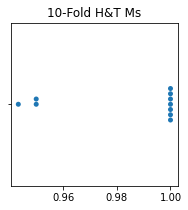

In [18]:
def hand_and_till_M_statistic(test_tgt, test_probs, weighted=False):
    def auc_helper(truth, probs):
        fpr,tpr, _ = metrics.roc_curve(truth,probs)
        return metrics.auc(fpr, tpr)
    classes = np.unique(test_tgt)
    n_classes = len(classes)
    indicator = preprocessing.label_binarize(test_tgt, classes)
    avg_auc_sum = 0.0
    for ij in it.combinations(classes,2):
        ij_indicator = indicator[:,ij].sum(axis=1,dtype=np.bool)
        ij_probs = test_probs[np.ix_(ij_indicator, ij)]
        ij_test_tgt = test_tgt[ij_indicator]
        i,j = ij
        auc_ij = auc_helper(ij_test_tgt==i, ij_probs[:,0])
        auc_ji = auc_helper(ij_test_tgt==j, ij_probs[:,1])
        avg_auc_ij = auc_ij + auc_ji
        if weighted:
            avg_auc_ij *= ij_indicator.sum()/len(test_tgt)
        avg_auc_sum += avg_auc_ij
    M = avg_auc_sum / (n_classes * (n_classes-1))
    return M

knn = neighbors.KNeighborsClassifier()
knn.fit(iris_train_ftrs, iris_train_tgt)
test_probs = knn.predict_proba(iris_test_ftrs)
hand_and_till_M_statistic(iris_test_tgt, test_probs)

fig, ax = plt.subplots(1,1,figsize=(3,3))
htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,needs_proba=True)
cv_auc = model_selection.cross_val_score(model, iris.data,iris.target,scoring=htm_scorer,cv=10)
sns.swarmplot(cv_auc,orient='v')
ax.set_title('10-Fold H&T Ms')

##### Precision - Recall curve

Text(0, 0.5, 'Precision')

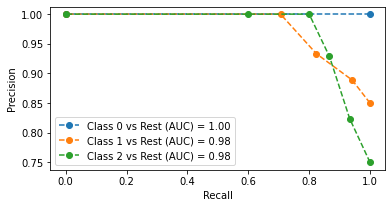

In [19]:
fix, ax = plt.subplots(figsize=(6,3))
for cls in [0,1,2]:
    prc = metrics.precision_recall_curve
    precision, recall, _ = prc(im_test_tgt[:,cls],pred_probs[:,cls])
    prc_auc = metrics.auc(recall, precision)
    label = "Class {} vs Rest (AUC) = {:,.2f}".format(cls,prc_auc)
    ax.plot(recall, precision, 'o--', label = label)
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')


The point at the top right of the PRC is perfect for us

In [20]:
myorder = np.argsort(-prob_true)
realpct_myorder = iris_1c_test_tgt[myorder].cumsum()
realpct_myorder = realpct_myorder/realpct_myorder[-1]
N = iris_1c_test_tgt.size
xs = np.linspace(1/N,1,N)
print(myorder[:3])


[ 0 28 43]


this says the firt 3 examples picked to classify as hits are 0, 28 and 43

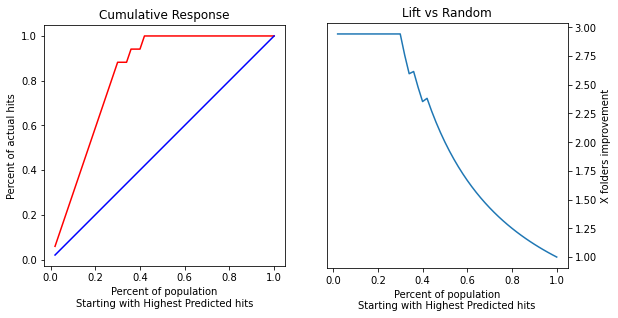

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
fig.tight_layout()
ax1.plot(xs,realpct_myorder,'r-')
ax1.plot(xs,xs,'b-')
ax1.axes.set_aspect('equal')

ax1.set_title("Cumulative Response")
ax1.set_ylabel("Percent of actual hits")
ax1.set_xlabel("Percent of population\n" + "Starting with Highest Predicted hits" )

ax2.plot(xs, realpct_myorder/np.where(xs>0,xs,1))
ax2.set_title("Lift vs Random")
ax2.set_ylabel("X folders improvement")
ax2.set_xlabel("Percent of population\n" + "Starting with Highest Predicted hits" )

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')


With cumulative response curve, y axis is effectively our TPR ( how well we are doing with respect to reality), x axis is percentage of our population to get the percent of actual hits. the curve shows with 40% population, we get 100% of the hits
with lift vs random curve ( also called lift curve or gain curve), simply devide performance of our classifier against the performance of a baseline random classifier ( devide of read line to blue line)

##### More sophisticated evaluatoin of classifer

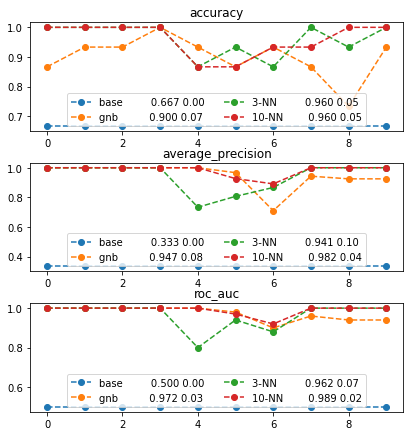

In [22]:
classifiers = {'base' : baseline,
               'gnb'  : naive_bayes.GaussianNB(),
               '3-NN' : neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN': neighbors.KNeighborsClassifier(n_neighbors=10)}
iris_onec_ftrs = iris.data
iris_onec_tgt = iris.target==1

msrs = ['accuracy','average_precision','roc_auc']
fig,axes = plt.subplots(len(msrs),1,figsize=(6,2*len(msrs)))
fig.tight_layout()
for mod_name,model in classifiers.items():
    cvs = model_selection.cross_val_score
    cv_results = {msr:cvs(model, iris_onec_ftrs, iris_onec_tgt, scoring=msr,cv=10) for msr in msrs}
    for ax, msr in zip(axes,msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,msr_results.mean(),msr_results.std())
        ax.plot(msr_results,'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2)

the charts indicate 10-NN seems working well than others , the GNB has very poor performance with 6 folds

Text(16.309090909090912, 0.5, 'Actual')

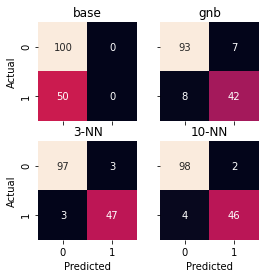

In [23]:
fig, axes = plt.subplots(2,2,figsize=(4,4),sharex=True, sharey=True)
for ax, (mod_name, model) in zip(axes.flat, classifiers.items()):
    preds = model_selection.cross_val_predict(model,iris_onec_ftrs, iris_onec_tgt,cv=10)
    cm = metrics.confusion_matrix(iris.target==1, preds)
    sns.heatmap(cm,annot=True,ax=ax,cbar=False,square=True,fmt="d")
    ax.set_title(mod_name)
axes[1,0].set_xlabel('Predicted')
axes[1,1].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[1,0].set_ylabel('Actual')


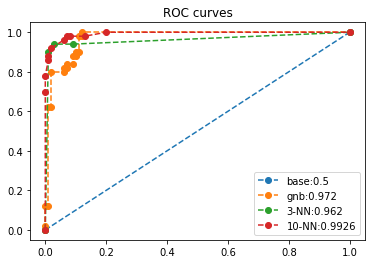

In [24]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
cv_prob_true = {}
for mod_name, model in classifiers.items():
    cv_probs = model_selection.cross_val_predict(model,iris_onec_ftrs,iris_onec_tgt,cv=10,method='predict_proba')
    cv_prob_true[mod_name] = cv_probs[:,1]
    fpr,tpr,thresh=metrics.roc_curve(iris_onec_tgt,cv_prob_true[mod_name])
    auc = metrics.auc(fpr,tpr)
    ax.plot(fpr,tpr,'o--',label="{}:{}".format(mod_name,auc))
ax.set_title("ROC curves")
ax.legend()

based on the ROC graph, we are probably most interested in our 3-NN model right now because of its slightly better AUC

Text(0.5, 1.0, 'Lift vs Random')

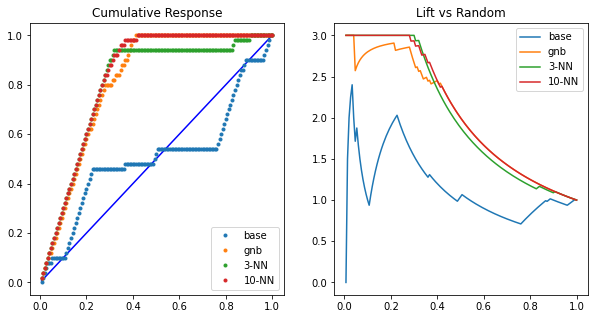

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
N = len(iris_onec_tgt)
xs = np.linspace(1/N,1,N)
ax1.plot(xs,xs,'b-')
for mod_name in classifiers:
    myorder = np.argsort(-cv_prob_true[mod_name])
    realpct_myorder = iris_onec_tgt[myorder].cumsum()
    realpct_myorder = realpct_myorder/realpct_myorder[-1]
    ax1.plot(xs, realpct_myorder,'.',label=mod_name)
    ax2.plot(xs, realpct_myorder/np.where(xs>0,xs,1),label=mod_name)
ax1.legend()
ax2.legend()
ax1.set_title("Cumulative Response")
ax2.set_title("Lift vs Random")


GBN fall off and then surpass 10-NN. 3-NN and GNB both peak out when targeting 40% of the population, 10-NN seem to hit a lull and doesn't hit 100% until near 100% targeting rate

##### A novel multiclass problem

In [26]:
student_url = ('http://archive.ics.uci.edu/'+'ml/machine-learning-databases/00320/student.zip')
def grab_student_numeric_discrete():
    import urllib.request, zipfile
    urllib.request.urlretrieve(student_url,'port_student.zip')
    zipfile.ZipFile('port_student.zip').extract('student-mat.csv')
    df = pd.read_csv('student-mat.csv',sep=';')
    df = df.drop(columns=['G1','G2']).select_dtypes(include=['number'])
    df['grade'] = pd.cut(df['G3'],[0,11,14,20],labels=['low','mid','high'],include_lowest=True)
    df.drop(columns=['G3'],inplace=True)
    df.to_csv('portugese_student_numeric_discrete.csv',index=False)
st_file = grab_student_numeric_discrete()

Text(0.5, 1.0, '10-fold accuracy')

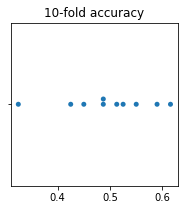

In [27]:
student_df = pd.read_csv('portugese_student_numeric_discrete.csv')
student_df['grade'] = pd.Categorical(student_df['grade'],categories=['low','mide','high'],ordered=True)
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt = student_df['grade'].cat.codes

(student_train_ftrs, student_test_ftrs, 
student_train_tgt, student_test_tgt) = model_selection.train_test_split(student_ftrs, student_tgt, test_size=.33, random_state=21)

fig,ax = plt.subplots(1,1,figsize=(3,3))
model = neighbors.KNeighborsClassifier(3)
cv_auc = model_selection.cross_val_score(model,student_ftrs,student_tgt,scoring='accuracy',cv=10)
ax = sns.swarmplot(cv_auc,orient='v')
ax.set_title("10-fold accuracy")

Text(0.5, 1.0, '10-fold macro precision')

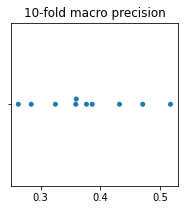

In [28]:
model = neighbors.KNeighborsClassifier(3)
my_scorer = metrics.make_scorer(metrics.precision_score,average='macro')
cv_auc = model_selection.cross_val_score(model,student_ftrs,student_tgt,scoring=my_scorer,cv=10)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(cv_auc,orient='v')
ax.set_title("10-fold macro precision")

Text(0.5, 1.0, '10-Fold H&T Ms')

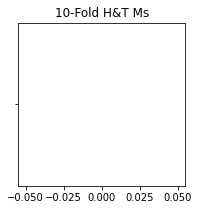

In [29]:
knn = neighbors.KNeighborsClassifier()
knn.fit(student_train_ftrs, student_train_tgt)
test_probs = knn.predict_proba(student_test_ftrs)
hand_and_till_M_statistic(student_test_tgt, test_probs)

htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,needs_proba=True)
htm_cv_auc = model_selection.cross_val_score(model, student_ftrs,student_tgt,scoring=htm_scorer,cv=10)
fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(htm_cv_auc,orient='v')
ax.set_title('10-Fold H&T Ms')

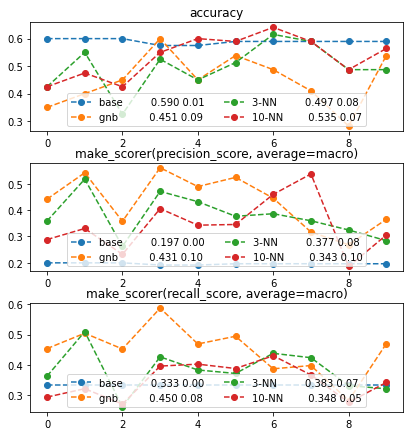

In [30]:
classifiers = {'base' : dummy.DummyClassifier(strategy="most_frequent"),
               'gnb'  : naive_bayes.GaussianNB(),
               '3-NN' : neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN': neighbors.KNeighborsClassifier(n_neighbors=10)}
macro_precision = metrics.make_scorer(metrics.precision_score, average='macro')
macro_recall = metrics.make_scorer(metrics.recall_score, average='macro')

msrs = ['accuracy',macro_precision,macro_recall]

fig,axes = plt.subplots(len(msrs),1,figsize=(6,2*len(msrs)))
fig.tight_layout()

for mod_name,model in classifiers.items():
    cvs = model_selection.cross_val_score
    cv_results = {msr:cvs(model, student_ftrs, student_tgt, scoring=msr,cv=10) for msr in msrs}
    for ax, msr in zip(axes,msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,msr_results.mean(),msr_results.std())
        ax.plot(msr_results,'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2) 

Text(25.63636363636364, 0.5, 'Actual')

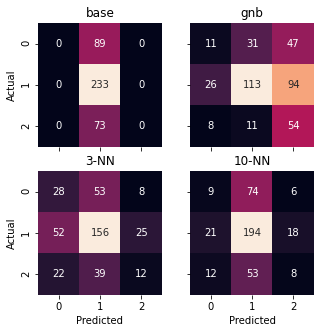

In [31]:
fig, axes = plt.subplots(2,2,figsize=(5,5),sharex=True, sharey=True)
for ax, (mod_name, model) in zip(axes.flat, classifiers.items()):
    preds = model_selection.cross_val_predict(model,student_ftrs, student_tgt,cv=10)
    cm = metrics.confusion_matrix(student_tgt, preds)
    sns.heatmap(cm,annot=True,ax=ax,cbar=False,square=True,fmt="d")
    ax.set_title(mod_name)
axes[1,0].set_xlabel('Predicted')
axes[1,1].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[1,0].set_ylabel('Actual')

##### Exercises 1 - Apply classification evaluation techniques to Wine datasets

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2


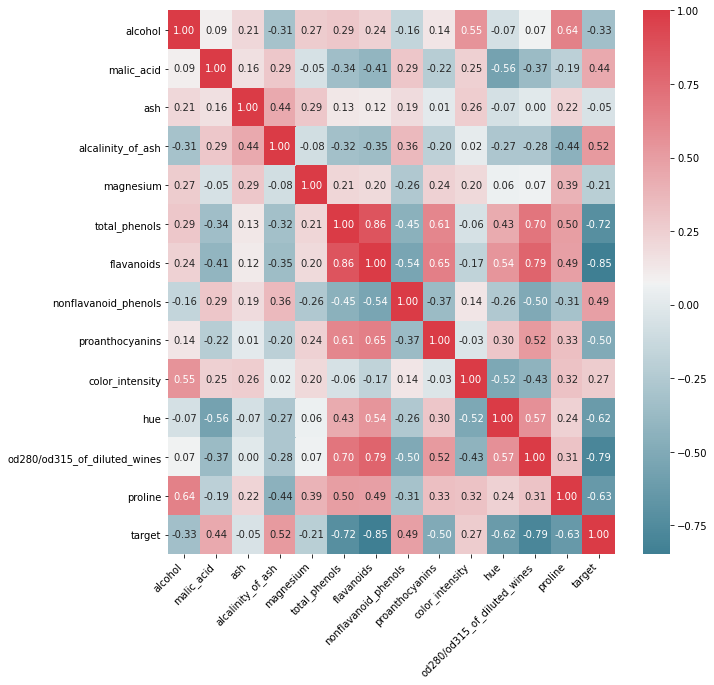

In [32]:
# Load wine data
wine = datasets.load_wine()
wine_df = pd.DataFrame(wine.data,columns=wine.feature_names)
wine_df['target'] = wine.target
display(pd.concat([wine_df.head(3),wine_df.tail(3)]))
wine_ftrs = wine_df.drop('target',1)
wine_tgt  = wine_df['target']
# evaluate relationship between features on chart
def df_correlation(dataset_df):
    correlations = dataset_df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(correlations, cmap=colormap, annot=True, fmt=".2f")
    ax.set_xticklabels(
    dataset_df.columns,
    rotation=45,
    horizontalalignment='right')
    ax.set_yticklabels(dataset_df.columns)
    plt.show()
df_correlation(wine_df)    

There are some relationships between these features with target
1. od280/od315_of_diluted_wines (-0.79)
2. total_phenols (-0.72)
3. flavanoids (-0.85)

Text(0.5, 1.0, '10-fold accuracy - wine')

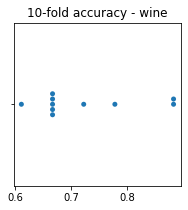

In [33]:
wine_model = neighbors.KNeighborsClassifier(3)
wine_cv_auc = model_selection.cross_val_score(wine_model,wine_ftrs,wine_tgt,scoring='accuracy',cv=10)
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax = sns.swarmplot(wine_cv_auc,orient='v')
ax.set_title("10-fold accuracy - wine")

Text(0.5, 1.0, '10-fold macro precision')

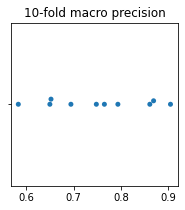

In [34]:
wine_model = neighbors.KNeighborsClassifier(3)
wine_my_scorer = metrics.make_scorer(metrics.precision_score,average='macro')
wine_cv_auc    = model_selection.cross_val_score(wine_model,wine_ftrs,wine_tgt,scoring=wine_my_scorer,cv=10)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(wine_cv_auc,orient='v')
ax.set_title("10-fold macro precision")

Text(0.5, 1.0, '10-Fold H&T Ms')

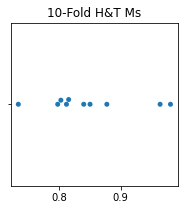

In [35]:
wine_model = neighbors.KNeighborsClassifier(3)
wine_htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,needs_proba=True)
wine_cv_auc = model_selection.cross_val_score(wine_model,wine.data,wine.target,scoring=wine_htm_scorer,cv=10)
fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(wine_cv_auc,orient='v')
ax.set_title('10-Fold H&T Ms')

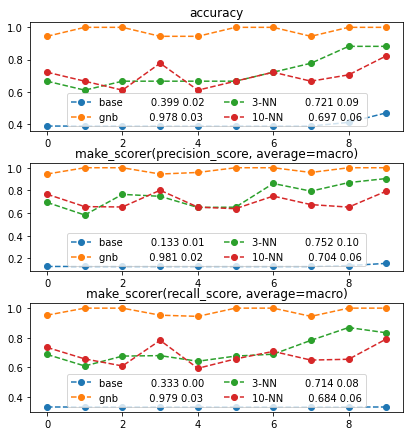

In [36]:
classifiers = {'base' : dummy.DummyClassifier(strategy="most_frequent"),
               'gnb'  : naive_bayes.GaussianNB(),
               '3-NN' : neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN': neighbors.KNeighborsClassifier(n_neighbors=10)}
macro_precision = metrics.make_scorer(metrics.precision_score, average='macro')
macro_recall = metrics.make_scorer(metrics.recall_score, average='macro')

msrs = ['accuracy',macro_precision,macro_recall]

fig,axes = plt.subplots(len(msrs),1,figsize=(6,2*len(msrs)))
fig.tight_layout()

for mod_name,wine_model in classifiers.items():
    cvs = model_selection.cross_val_score
    cv_results = {msr:cvs(wine_model, wine_ftrs, wine_tgt, scoring=msr,cv=10) for msr in msrs}
    for ax, msr in zip(axes,msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,msr_results.mean(),msr_results.std())
        ax.plot(msr_results,'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2)         

The chart indicate that GNB model do better than others for all scores 

##### Exercises 2 - Apply classification evaluation techniques to Breast Cancer datasets

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.4280,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


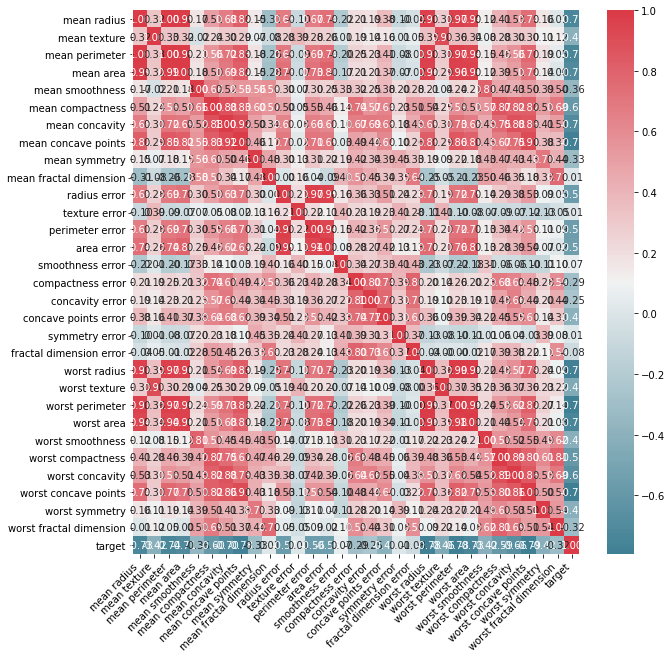

In [37]:
# Load breast cancer data
breast = datasets.load_breast_cancer()
breast_df = pd.DataFrame(breast.data,columns=breast.feature_names)
breast_df['target'] = breast.target
display(pd.concat([breast_df.head(3),breast_df.tail(3)]))
breast_ftrs = breast_df.drop('target',1)
breast_tgt  = breast_df['target']
# evaluate relationship between features on chart
df_correlation(breast_df)

Text(0.5, 1.0, '10-fold accuracy - breast cancer')

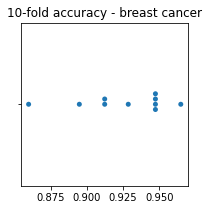

In [38]:
breast_model = neighbors.KNeighborsClassifier(3)
breast_cv_auc = model_selection.cross_val_score(breast_model,breast_ftrs,breast_tgt,scoring='accuracy',cv=10)
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax = sns.swarmplot(breast_cv_auc,orient='v')
ax.set_title("10-fold accuracy - breast cancer")

Text(0.5, 1.0, '10-fold macro precision - breast cancer')

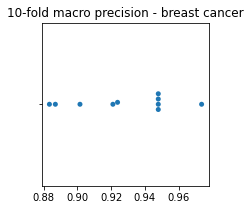

In [39]:
breast_model = neighbors.KNeighborsClassifier(3)
breast_my_scorer = metrics.make_scorer(metrics.precision_score,average='macro')
breast_cv_auc    = model_selection.cross_val_score(breast_model,breast_ftrs,breast_tgt,scoring=breast_my_scorer,cv=10)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(breast_cv_auc,orient='v')
ax.set_title("10-fold macro precision - breast cancer")

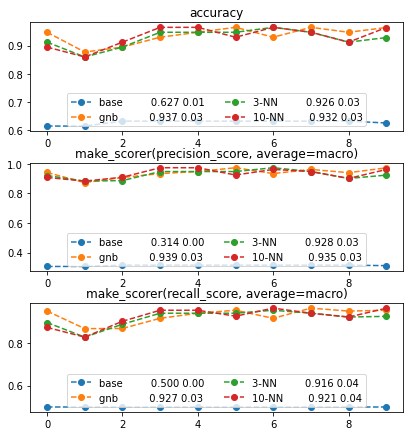

In [40]:
classifiers = {'base' : dummy.DummyClassifier(strategy="most_frequent"),
               'gnb'  : naive_bayes.GaussianNB(),
               '3-NN' : neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN': neighbors.KNeighborsClassifier(n_neighbors=10)}
macro_precision = metrics.make_scorer(metrics.precision_score, average='macro')
macro_recall = metrics.make_scorer(metrics.recall_score, average='macro')

msrs = ['accuracy',macro_precision,macro_recall]

fig,axes = plt.subplots(len(msrs),1,figsize=(6,2*len(msrs)))
fig.tight_layout()

for mod_name,breast_model in classifiers.items():
    cvs = model_selection.cross_val_score
    cv_results = {msr:cvs(breast_model, breast_ftrs, breast_tgt, scoring=msr,cv=10) for msr in msrs}
    for ax, msr in zip(axes,msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,msr_results.mean(),msr_results.std())
        ax.plot(msr_results,'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2)         

GNB seems a good classifier than other